### Damped cubic oscillator

In [1]:
%pylab inline

import numpy as np
import tensorflow as tf
from scipy.integrate import odeint
from utils_var_step import *
np.random.seed(0)

#
#
noise_percent = 10
#
#

Populating the interactive namespace from numpy and matplotlib


### Generate data

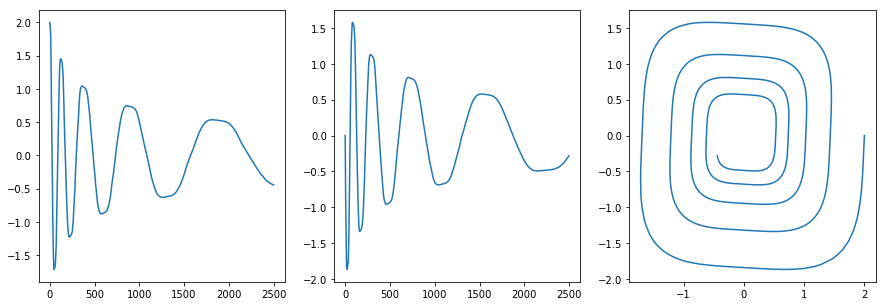

In [2]:
def damped_cubic_osc(X, t):
    x,y = X
    return [-0.1*x**3 + 2.0*y**3, -2.0*x**3 - 0.1*y**3]

M = 25000
subsample_rate = 10

subsample = [j for j in range(M) if j%subsample_rate == 0]
m = len(subsample)
n = 2

T_max = 25
t_full = np.cumsum(np.random.exponential(size = M))
t_full = t_full*T_max/t_full[-1]
t = t_full[subsample]

X = odeint(damped_cubic_osc, [2,0], t_full, rtol = 1e-12, atol = 1e-12)[subsample, :].T
x = X[0,:]; y = X[1,:]

pylab.rcParams['figure.figsize'] = (15,5)
subplot(1,3,1); plot(x)
subplot(1,3,2); plot(y)
subplot(1,3,3); plot(x,y)

In [3]:
noise_level = 0.01*noise_percent*np.std(X)
measurement_noise = noise_level*np.random.randn(*X.shape)

Y = X + measurement_noise
print(noise_level)

0.0625637860671


In [4]:
N_hat, X_hat = approximate_noise(Y,t,lam = 1e-6)

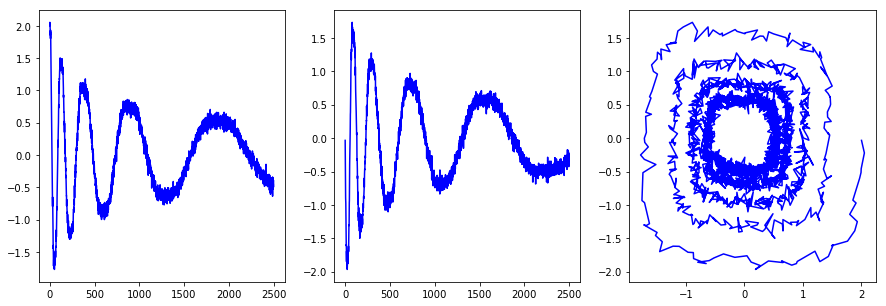

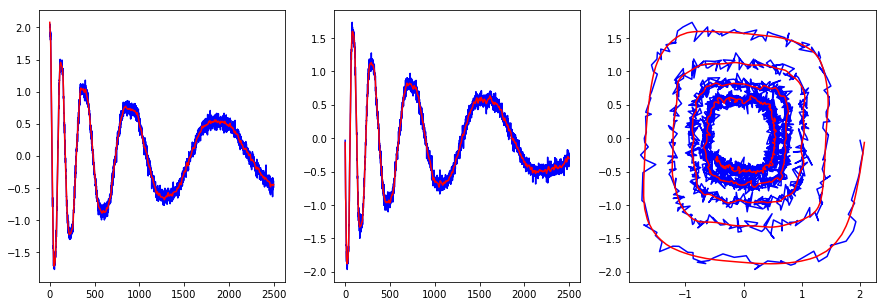

In [5]:
figure(figsize = (15,5))
subplot(1,3,1); plot(Y[0,:], 'b')
subplot(1,3,2); plot(Y[1,:], 'b')
subplot(1,3,3); plot(Y[0,:],Y[1,:], 'b')

figure(figsize = (15,5))
subplot(1,3,1); plot(Y[0,:], 'b'); plot(X_hat[0,:], 'r')
subplot(1,3,2); plot(Y[1,:], 'b'); plot(X_hat[1,:], 'r')
subplot(1,3,3); plot(Y[0,:],Y[1,:], 'b'); plot(X_hat[0,:],X_hat[1,:], 'r')

### Train 

In [6]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

net_params = get_network_variables(n, 3, 32, N_hat)
optimizer, placeholders = create_computational_graph(n, N_hat, net_params)

init = tf.global_variables_initializer()
sess.run(init)

In [7]:
num_dt = 10

feed_dict = {placeholders['Y_0']: Y[:,num_dt:m-num_dt], 
             placeholders['T_0']: t[num_dt:-num_dt].reshape(1,m-2*num_dt),
             placeholders['H']: (t[1:]-t[:-1]).reshape(1,m-1)}

for j in range(num_dt):
    feed_dict[placeholders['true_forward_Y'][j]] = Y[:,num_dt+j+1:m-num_dt+j+1]
    feed_dict[placeholders['true_backward_Y'][j]] = Y[:,num_dt-j-1:m-num_dt-j-1]

optimizer.minimize(sess, feed_dict=feed_dict)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.000095
  Number of iterations: 4949
  Number of functions evaluations: 5388


In [8]:
X_test = np.zeros((2,m))
X_test[:,0] = X[:,0]

h = tf.placeholder(tf.float32, [1,1], name = "h")
weights, biases, N = net_params

x_next_test = RK_timestepper(placeholders['Y_0'], placeholders['T_0'], simple_net, h, weights, biases)

for j in range(m-1):
    X_test[:,j+1] = sess.run(x_next_test, feed_dict={placeholders['Y_0']: np.array([X_test[:,j]]).T, 
                                                    placeholders['T_0']: np.array([[0]]), 
                                                    h: np.array([[t[j+1]-t[j]]])}).flatten()

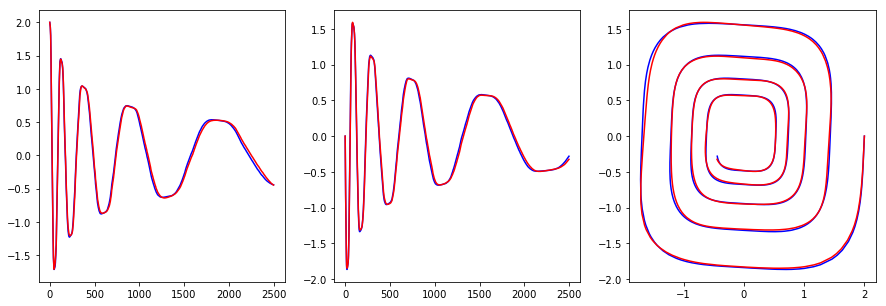

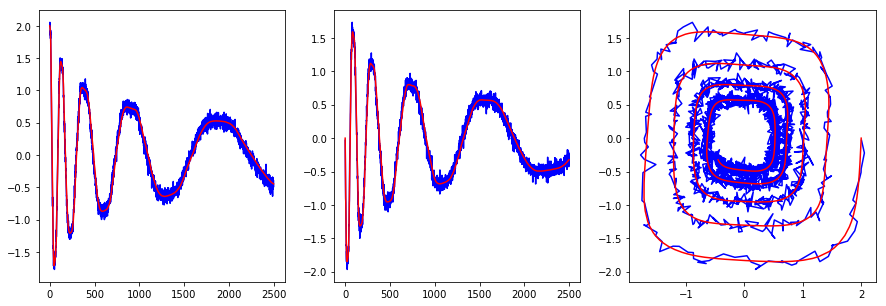

In [9]:
figure(figsize = (15,5))
subplot(1,3,1); plot(X[0,:], 'b'); plot(X_test[0,:], 'r')
subplot(1,3,2); plot(X[1,:], 'b'); plot(X_test[1,:], 'r')
subplot(1,3,3); plot(X[0,:],X[1,:], 'b'); plot(X_test[0,:],X_test[1,:], 'r')

figure(figsize = (15,5))
subplot(1,3,1); plot(Y[0,:], 'b'); plot(X_test[0,:], 'r')
subplot(1,3,2); plot(Y[1,:], 'b'); plot(X_test[1,:], 'r')
subplot(1,3,3); plot(Y[0,:],Y[1,:], 'b'); plot(X_test[0,:],X_test[1,:], 'r')

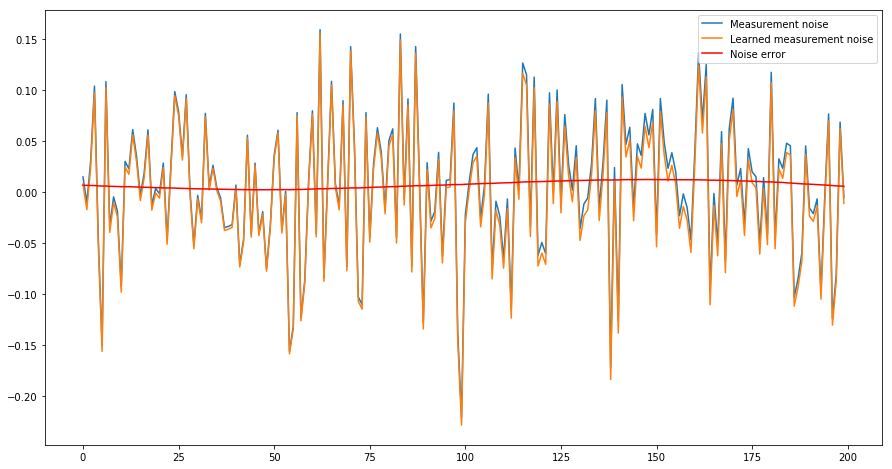

In [10]:
start = 1000
end = 1200

figure(figsize = (15,8))

plot(measurement_noise[0,start:end], label = 'Measurement noise')
plot(N.eval()[0,start:end], label = 'Learned measurement noise')
plot(measurement_noise[0,start:end] - N.eval()[0,start:end], 'r', label = 'Noise error')
legend(loc='upper right')

In [11]:
N_gaussian = N.eval()

In [12]:
true_vector_field = np.stack([-0.1*x**3 + 2.0*y**3, -2.0*x**3 - 0.1*y**3], axis = 0)
approx_vec_field = sess.run(simple_net(placeholders['Y_0'], weights, biases), feed_dict = {placeholders['Y_0']: X})

noise_error = np.linalg.norm(measurement_noise - N.eval(),'fro')**2 / m
vector_field_error = np.linalg.norm(true_vector_field - approx_vec_field,'fro')**2 / np.linalg.norm(true_vector_field,'fro')**2
trajectory_error = np.linalg.norm(X-X_test,'fro')**2 / np.linalg.norm(X,'fro')**2

print(noise_error)
print(vector_field_error)
print(trajectory_error)

0.000129714391645
0.00272442829595
0.00512449141996
